# Init

## import

In [1]:
import pandas as pd
import numpy as np
import re

In [2]:
cd ..

/Users/wliao0504/code/clif/CLIF-MIMIC


/Users/wliao0504/code/clif/CLIF-MIMIC/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
pwd

'/Users/wliao0504/code/clif/CLIF-MIMIC'

In [4]:
# %load_ext autoreload
# %autoreload 2

from src.utils import check_duplicates, find_duplicates, read_from_rclif, clif_table_pathfinder, \
    mimic_table_pathfinder

loaded configuration from /Users/wliao0504/code/clif/CLIF-MIMIC/src/../config/config.json


## load pipeline

In [43]:
import importlib
from src.tables import labs 
importlib.reload(labs)

from src import utils
importlib.reload(utils)

loaded configuration from /Users/wliao0504/code/clif/CLIF-MIMIC/src/../config/config.json


<module 'src.utils' from '/Users/wliao0504/code/clif/CLIF-MIMIC/src/utils.py'>

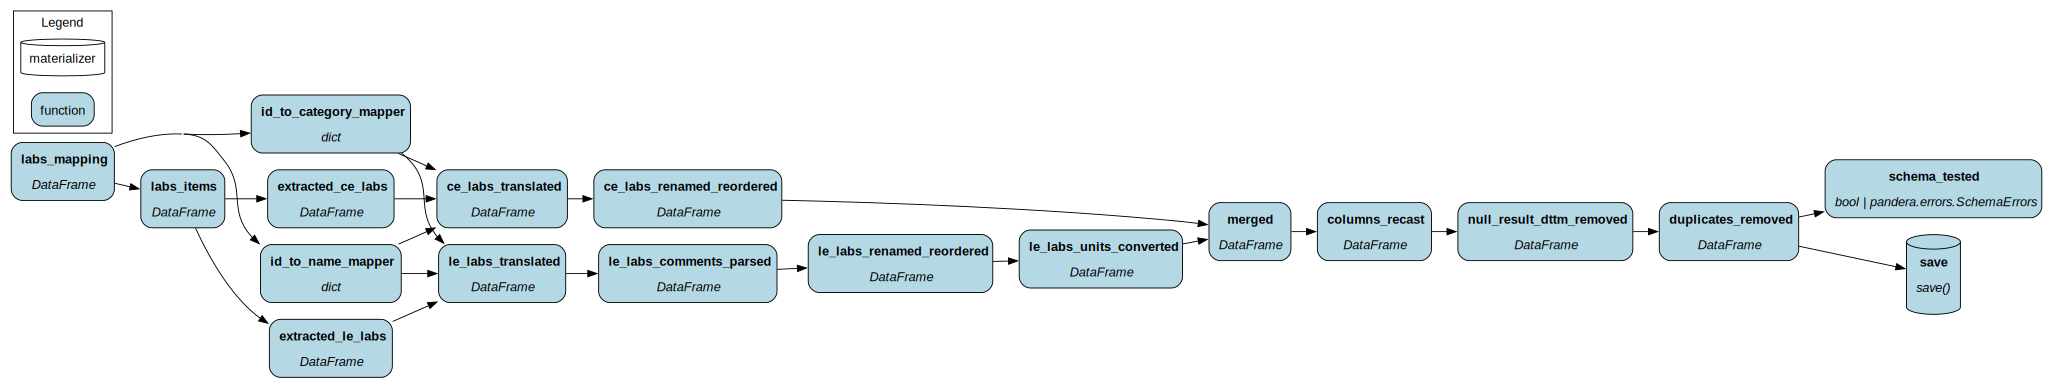

In [44]:
from hamilton import driver
from hamilton.caching.stores.memory import InMemoryMetadataStore, InMemoryResultStore

dr = (
    driver.Builder()
    .with_modules(labs)
    # .with_cache(
    #     result_store=InMemoryResultStore(),
    #     metadata_store=InMemoryMetadataStore(),
    # )
    .build()
)
dr.display_all_functions()

# Dev

## test

In [45]:
# results = dr.execute(["duplicates_removed", "schema_tested"])
results = labs._test()
error = results["schema_tested"]

2025-04-27 12:34:24,964 - INFO - testing all...
2025-04-27 12:34:24,966 - INFO - initialized logging at logs/etl.log
2025-04-27 12:34:24,968 - INFO - starting data extraction
2025-04-27 12:34:24,969 - INFO - loading mapping...
2025-04-27 12:34:24,972 - INFO - filtering labs items...
2025-04-27 12:34:24,973 - INFO - identifying lab items to be extracted from labevents table...
2025-04-27 12:34:24,974 - INFO - extracting from labevents table...
2025-04-27 12:35:05,840 - INFO - constructing item id to name mapper...
2025-04-27 12:35:05,846 - INFO - constructing item id to category mapper...
2025-04-27 12:35:05,847 - INFO - translating labevents item ids to lab names and categories...
2025-04-27 12:35:07,138 - INFO - parsing lab comments to recover otherwise missing lab values...
2025-04-27 12:35:08,865 - INFO - renaming and reordering labevents columns...
2025-04-27 12:35:46,456 - INFO - converting units of measurement...
2025-04-27 12:35:49,683 - INFO - identifying lab items to be extrac

In [ ]:
error.data.loc[error.failure_cases["index"],:]

In [ ]:
le_labs_translated = results["le_labs_translated"]

In [13]:
dr.cache.view_run()

IndexError: list index out of range

## check NA time issue

In [31]:
results = dr.execute(["ce_labs_renamed_reordered", "le_labs_renamed_reordered", "columns_recast"])

2025-04-27 12:16:48,476 - INFO - starting data extraction
2025-04-27 12:16:48,477 - INFO - loading mapping...
2025-04-27 12:16:48,481 - INFO - filtering labs items...
2025-04-27 12:16:48,482 - INFO - identifying lab items to be extracted from chartevents table...
2025-04-27 12:16:48,483 - INFO - extracting from chartevents table...
2025-04-27 12:16:48,483 - INFO - querying the d_items table to identify which event tables to be separately queried for 11 items
2025-04-27 12:16:48,486 - INFO - identified 1 event tables to be separately queried: ['chartevents']
2025-04-27 12:16:48,487 - INFO - fetching events from chartevents table for 11 items
2025-04-27 12:16:53,181 - INFO - fetched 1838520 events from chartevents table for 11 items
2025-04-27 12:16:53,182 - INFO - concatenated 1838520 events from 1 event table(s)
2025-04-27 12:16:53,182 - INFO - constructing item id to name mapper...
2025-04-27 12:16:53,184 - INFO - constructing item id to category mapper...
2025-04-27 12:16:53,184 - IN

In [32]:
ce_labs_renamed_reordered: pd.DataFrame = results['ce_labs_renamed_reordered']
le_labs_renamed_reordered: pd.DataFrame = results['le_labs_renamed_reordered']
columns_recast: pd.DataFrame = results['columns_recast']

In [39]:
# check that the chartevents table are pretty "clean" -- with no NA values for any of the 3 columns
mask = ce_labs_renamed_reordered["lab_value_numeric"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_value_numeric` in 'ce_labs_renamed_reordered'")

mask = ce_labs_renamed_reordered["lab_collect_dttm"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_collect_dttm` in 'ce_labs_renamed_reordered'")

mask = ce_labs_renamed_reordered["lab_result_dttm"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_result_dttm` in 'ce_labs_renamed_reordered'")
na_result_dttm = ce_labs_renamed_reordered[mask]
na_result_dttm.head()

0 (0.0%) rows have NaN for `lab_value_numeric` in 'ce_labs_renamed_reordered'
0 (0.0%) rows have NaN for `lab_collect_dttm` in 'ce_labs_renamed_reordered'
0 (0.0%) rows have NaN for `lab_result_dttm` in 'ce_labs_renamed_reordered'


,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code,itemid


In [41]:
# check that the issues are with labevents table
mask = le_labs_renamed_reordered["lab_value_numeric"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_value_numeric` in 'le_labs_renamed_reordered'")
na_lab_value_numeric = le_labs_renamed_reordered[mask]

mask = le_labs_renamed_reordered["lab_collect_dttm"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_collect_dttm` in 'le_labs_renamed_reordered'")

mask = le_labs_renamed_reordered["lab_result_dttm"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_result_dttm` in 'le_labs_renamed_reordered'")
na_result_dttm = le_labs_renamed_reordered[mask]
na_result_dttm.head()

80213 (0.2%) rows have NaN for `lab_value_numeric` in 'le_labs_renamed_reordered'
0 (0.0%) rows have NaN for `lab_collect_dttm` in 'le_labs_renamed_reordered'
35 (0.0%) rows have NaN for `lab_result_dttm` in 'le_labs_renamed_reordered'


,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code,itemid
467869,25061074,NaN,2173-03-24 18:02:00,NaT,NaN,NaN,pCO2,pco2_arterial,None,NaN,mm Hg,NaN,NaN,NaN,50818
467870,25061074,NaN,2173-03-24 18:02:00,NaT,NaN,NaN,pH,ph_arterial,None,NaN,units,NaN,NaN,NaN,50820
467871,25061074,NaN,2173-03-24 18:02:00,NaT,NaN,NaN,pO2,po2_arterial,None,NaN,mm Hg,NaN,NaN,NaN,50821
2805117,28168342,NaN,2164-08-10 09:41:00,NaT,NaN,NaN,pH,ph_arterial,None,NaN,units,NaN,NaN,NaN,50820
4775322,29789360,NaN,2163-12-30 05:23:00,NaT,NaN,NaN,pCO2,pco2_arterial,None,NaN,mm Hg,NaN,NaN,NaN,50818


This prompted us to not remove these rows and instead keep them as they are in tandom with the `lab_value` which is sourced from the original comment, in case we had any issue with parsing the comments.

In [42]:
na_lab_value_numeric

,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code,itemid
2808,22987108,NaN,2146-07-12 03:10:00,2146-07-12 04:55:00,NaN,NaN,Hemoglobin,hemoglobin,UNABLE TO REPORT.,NaN,g/dL,NaN,NaN,NaN,51222
6696,27660382,NaN,2146-03-11 05:00:00,2146-03-11 06:58:00,NaN,NaN,INR(PT),inr,UNABLE TO REPORT.,NaN,None,NaN,NaN,NaN,51237
6697,27660382,NaN,2146-03-11 05:00:00,2146-03-11 06:58:00,NaN,NaN,PT,pt,___,NaN,sec,NaN,NaN,NaN,51274
6698,27660382,NaN,2146-03-11 05:00:00,2146-03-11 06:58:00,NaN,NaN,PTT,ptt,UNABLE TO REPORT.,NaN,sec,NaN,NaN,NaN,51275
7323,24757479,NaN,2146-06-29 00:00:00,2146-06-29 01:21:00,NaN,NaN,Basophils,basophils_percent,NOT DONE.,NaN,%,NaN,NaN,NaN,51146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44330415,26445739,NaN,2113-12-14 06:46:00,2113-12-14 07:40:00,NaN,NaN,PT,pt,___,NaN,sec,NaN,NaN,NaN,51274
44330416,26445739,NaN,2113-12-14 06:46:00,2113-12-14 07:40:00,NaN,NaN,PTT,ptt,UNABLE TO REPORT.,NaN,sec,NaN,NaN,NaN,51275
44332303,22183763,NaN,2114-02-17 21:40:00,2114-02-17 22:34:00,NaN,NaN,Platelet Count,platelet_count,___,NaN,K/uL,NaN,NaN,NaN,51265
44332358,22183763,NaN,2114-02-18 14:17:00,2114-02-18 16:14:00,NaN,NaN,Platelet Count,platelet_count,UNABLE TO REPORT.,NaN,K/uL,NaN,NaN,NaN,51265


In [34]:
mask = le_labs_renamed_reordered["lab_collect_dttm"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_collect_dttm`")

mask = le_labs_renamed_reordered["lab_result_dttm"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_result_dttm`")
na_result_dttm = le_labs_renamed_reordered[mask]
na_result_dttm.head()

0 (0.0%) rows have NaN for `lab_collect_dttm`
35 (0.0%) rows have NaN for `lab_result_dttm`


,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code,itemid
467869,25061074,NaN,2173-03-24 18:02:00,NaT,NaN,NaN,pCO2,pco2_arterial,None,NaN,mm Hg,NaN,NaN,NaN,50818
467870,25061074,NaN,2173-03-24 18:02:00,NaT,NaN,NaN,pH,ph_arterial,None,NaN,units,NaN,NaN,NaN,50820
467871,25061074,NaN,2173-03-24 18:02:00,NaT,NaN,NaN,pO2,po2_arterial,None,NaN,mm Hg,NaN,NaN,NaN,50821
2805117,28168342,NaN,2164-08-10 09:41:00,NaT,NaN,NaN,pH,ph_arterial,None,NaN,units,NaN,NaN,NaN,50820
4775322,29789360,NaN,2163-12-30 05:23:00,NaT,NaN,NaN,pCO2,pco2_arterial,None,NaN,mm Hg,NaN,NaN,NaN,50818


In [ ]:
mask = columns_recast["lab_collect_dttm"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_collect_dttm`")

mask = columns_recast["lab_result_dttm"].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `lab_result_dttm`")
na_result_dttm = columns_recast[mask]
na_result_dttm.head()

0 (0.0%) rows have NaN for `lab_collect_dttm`
35 (0.0%) rows have NaN for `lab_result_dttm`


,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code
471517,25061074,NaT,2173-03-24 23:02:00+00:00,NaT,<NA>,<NA>,pCO2,pco2_arterial,None,NaN,mm Hg,<NA>,<NA>,<NA>
471518,25061074,NaT,2173-03-24 23:02:00+00:00,NaT,<NA>,<NA>,pH,ph_arterial,None,NaN,units,<NA>,<NA>,<NA>
471519,25061074,NaT,2173-03-24 23:02:00+00:00,NaT,<NA>,<NA>,pO2,po2_arterial,None,NaN,mm Hg,<NA>,<NA>,<NA>
2851518,28168342,NaT,2164-08-10 14:41:00+00:00,NaT,<NA>,<NA>,pH,ph_arterial,None,NaN,units,<NA>,<NA>,<NA>
4810753,29789360,NaT,2163-12-30 10:23:00+00:00,NaT,<NA>,<NA>,pCO2,pco2_arterial,None,NaN,mm Hg,<NA>,<NA>,<NA>


A lot of these NA lab result time is valid in the sense that there was no value recorded either, indicating there was likely something that might have gone wrong in the labs so not result is available. This should prompt us to look closer into the comment issue

## dedup

In [14]:
labs_events_f = read_from_rclif("labs_intm")

In [15]:
len(labs_events_f)

46174325

In [4]:
labs_dups = find_duplicates(labs_events_f, ["hospitalization_id", "lab_collect_dttm", "lab_result_dttm", "lab_category"]) \
    .sort_values(["hospitalization_id", "lab_collect_dttm", "lab_result_dttm", "lab_category"])

labs_dups

,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code
9683715,20000147,NaT,2121-08-30 17:38:00,2121-08-30 17:39:00,,,pCO2,pco2_arterial,35,35.00,mm Hg,,,
44761220,20000147,NaT,2121-08-30 17:38:00,2121-08-30 17:39:00,,,Arterial CO2 Pressure,pco2_arterial,35,35.00,mmHg,,,
9683716,20000147,NaT,2121-08-30 17:38:00,2121-08-30 17:39:00,,,pH,ph_arterial,7.41,7.41,units,,,
44762337,20000147,NaT,2121-08-30 17:38:00,2121-08-30 17:39:00,,,PH (Arterial),ph_arterial,7.41,7.41,units,,,
9683717,20000147,NaT,2121-08-30 17:38:00,2121-08-30 17:39:00,,,pO2,po2_arterial,390,390.00,mm Hg,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44775215,29999625,NaT,2157-11-24 02:37:00,2157-11-24 02:40:00,,,Arterial CO2 Pressure,pco2_arterial,43,43.00,mmHg,,,
4567471,29999625,NaT,2157-11-24 02:37:00,2157-11-24 02:40:00,,,pH,ph_arterial,7.41,7.41,units,,,
44776501,29999625,NaT,2157-11-24 02:37:00,2157-11-24 02:40:00,,,PH (Arterial),ph_arterial,7.41,7.41,units,,,
4567472,29999625,NaT,2157-11-24 02:37:00,2157-11-24 02:40:00,,,pO2,po2_arterial,81,81.00,mm Hg,,,


In [5]:
# Drop trivial duplicates
labs_events_fd = labs_events_f.drop_duplicates(
        subset = ["hospitalization_id", "lab_collect_dttm", "lab_result_dttm", "lab_category", "lab_value_numeric"],
        inplace = False)

After we drop the trivial duplicates (where the values are the same and thus simply repeated), we are left with 4015 non-trivial cases: 

In [6]:
labs_dups_d = find_duplicates(labs_events_fd, ["hospitalization_id", "lab_collect_dttm", "lab_result_dttm", "lab_category"]) \
    .sort_values(["hospitalization_id", "lab_collect_dttm", "lab_result_dttm", "lab_category"])

labs_dups_d

,hospitalization_id,lab_order_dttm,lab_collect_dttm,lab_result_dttm,lab_order_name,lab_order_category,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit,lab_specimen_name,lab_specimen_category,lab_loinc_code
18566630,20012928,NaT,2123-03-02 04:45:00,2123-03-02 05:48:00,,,Hemoglobin,hemoglobin,7.7,7.7,g/dL,,,
18566642,20012928,NaT,2123-03-02 04:45:00,2123-03-02 05:48:00,,,Hemoglobin,hemoglobin,7.6,7.6,g/dL,,,
18566631,20012928,NaT,2123-03-02 04:45:00,2123-03-02 05:48:00,,,Platelet Count,platelet_count,148,148.0,K/uL,,,
18566643,20012928,NaT,2123-03-02 04:45:00,2123-03-02 05:48:00,,,Platelet Count,platelet_count,139,139.0,K/uL,,,
38581298,20025172,NaT,2139-12-01 08:38:00,2139-12-01 10:31:00,,,Hemoglobin,hemoglobin,7.7,7.7,g/dL,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22382782,29983564,NaT,2128-06-07 06:47:00,2128-06-07 08:42:00,,,PT,pt,12.3,12.3,sec,,,
22382766,29983564,NaT,2128-06-07 06:47:00,2128-06-07 08:42:00,,,PTT,ptt,28.4,28.4,sec,,,
22382783,29983564,NaT,2128-06-07 06:47:00,2128-06-07 08:42:00,,,PTT,ptt,28.7,28.7,sec,,,
44677336,29984509,NaT,2158-10-22 12:00:00,2158-10-22 12:04:00,,,Mixed Venous O2% Sat,so2_mixed_venous,42,42.0,%,,,


If we discard duplicates that result from many to one mapping (which we can solve by assigning duduplication rank), we are left with the case of geneinue duplicates from the same item (displayed below). Luckily, most of them seem to be close-value duplicates (which we may define as being within 10% from each other). Then the remaining are the most thorny cases: observations of the same item of the same patient at same time that differ dramatically in values. Should we drop either? both? Or are they legit duplicates from two different samples / specimens?
 

In [7]:
labs_dups_d2 = find_duplicates(labs_events_fd, ["hospitalization_id", "lab_collect_dttm", "lab_result_dttm", "lab_name"]) \
    .sort_values(["hospitalization_id", "lab_collect_dttm", "lab_result_dttm", "lab_category"])

In [8]:
# remove some empty columns for better display
labs_dups_d2.drop(
    columns = ["lab_order_dttm", "lab_order_name", "lab_order_category", "lab_specimen_name", "lab_specimen_category", "lab_loinc_code"],
    inplace = True
    )
labs_dups_d2

,hospitalization_id,lab_collect_dttm,lab_result_dttm,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit
18566630,20012928,2123-03-02 04:45:00,2123-03-02 05:48:00,Hemoglobin,hemoglobin,7.7,7.7,g/dL
18566642,20012928,2123-03-02 04:45:00,2123-03-02 05:48:00,Hemoglobin,hemoglobin,7.6,7.6,g/dL
18566631,20012928,2123-03-02 04:45:00,2123-03-02 05:48:00,Platelet Count,platelet_count,148,148.0,K/uL
18566643,20012928,2123-03-02 04:45:00,2123-03-02 05:48:00,Platelet Count,platelet_count,139,139.0,K/uL
38581298,20025172,2139-12-01 08:38:00,2139-12-01 10:31:00,Hemoglobin,hemoglobin,7.7,7.7,g/dL
...,...,...,...,...,...,...,...,...
39224708,29977045,2134-12-23 11:35:00,2134-12-23 13:16:00,Hemoglobin,hemoglobin,6.9,6.9,g/dL
22382765,29983564,2128-06-07 06:47:00,2128-06-07 08:42:00,PT,pt,12.4,12.4,sec
22382782,29983564,2128-06-07 06:47:00,2128-06-07 08:42:00,PT,pt,12.3,12.3,sec
22382766,29983564,2128-06-07 06:47:00,2128-06-07 08:42:00,PTT,ptt,28.4,28.4,sec


In [9]:
labs_dups_d2

,hospitalization_id,lab_collect_dttm,lab_result_dttm,lab_name,lab_category,lab_value,lab_value_numeric,reference_unit
18566630,20012928,2123-03-02 04:45:00,2123-03-02 05:48:00,Hemoglobin,hemoglobin,7.7,7.7,g/dL
18566642,20012928,2123-03-02 04:45:00,2123-03-02 05:48:00,Hemoglobin,hemoglobin,7.6,7.6,g/dL
18566631,20012928,2123-03-02 04:45:00,2123-03-02 05:48:00,Platelet Count,platelet_count,148,148.0,K/uL
18566643,20012928,2123-03-02 04:45:00,2123-03-02 05:48:00,Platelet Count,platelet_count,139,139.0,K/uL
38581298,20025172,2139-12-01 08:38:00,2139-12-01 10:31:00,Hemoglobin,hemoglobin,7.7,7.7,g/dL
...,...,...,...,...,...,...,...,...
39224708,29977045,2134-12-23 11:35:00,2134-12-23 13:16:00,Hemoglobin,hemoglobin,6.9,6.9,g/dL
22382765,29983564,2128-06-07 06:47:00,2128-06-07 08:42:00,PT,pt,12.4,12.4,sec
22382782,29983564,2128-06-07 06:47:00,2128-06-07 08:42:00,PT,pt,12.3,12.3,sec
22382766,29983564,2128-06-07 06:47:00,2128-06-07 08:42:00,PTT,ptt,28.4,28.4,sec


In [10]:
len(labs_events_f)

46174325

In [11]:
f"{(3615 / len(labs_events_f)) * 100:.2f}%"

7.829026195835023e-05

## handle NA lab values (`valuenum`)
sometimes the `value` or `valuenum` are NA, or in a weird blank form "__". need to check if they are always accompanied by otherwise useful comments. This seems a problem unique to the labs events (le) table.

In [18]:
df_le: pd.DataFrame = le_labs_translated

df_le.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,lab_name,lab_category
0,373283,10023274,25335412,18902407,51146,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,0.4,0.4,%,0.0,1.0,<NA>,STAT,<NA>,Basophils,basophils_percent
1,373284,10023274,25335412,18902407,51200,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,0.2,0.2,%,1.0,7.0,abnormal,STAT,<NA>,Eosinophils,eosinophils_percent
2,373286,10023274,25335412,18902407,51222,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,13.6,13.6,g/dL,13.7,17.5,abnormal,STAT,<NA>,Hemoglobin,hemoglobin
3,373287,10023274,25335412,18902407,51244,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,21.1,21.1,%,19.0,53.0,<NA>,STAT,<NA>,Lymphocytes,lymphocytes_percent
4,373291,10023274,25335412,18902407,51254,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,7.8,7.8,%,5.0,13.0,<NA>,STAT,<NA>,Monocytes,monocytes_percent


In [19]:
# We start by examining the numeric value field `valuenum`
mask = df_le['valuenum'].isna()
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `valuenum`")
na_valuenum: pd.DataFrame = df_le[mask]
na_valuenum.head()

223966 (0.5%) rows have NaN for `valuenum`


,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,lab_name,lab_category
11,373308,10023274,25335412,61097845,51003,<NA>,2155-01-08 21:21:00,2155-01-08 22:17:00,<NA>,<NA>,ng/mL,0.0,0.01,<NA>,STAT,<0.01. cTropnT > 0.10 ng/mL suggests Acute MI.,Troponin T,troponin_t
35,373346,10023274,25335412,93866128,51003,<NA>,2155-01-09 06:55:00,2155-01-09 09:06:00,<NA>,<NA>,ng/mL,0.0,0.01,<NA>,ROUTINE,<0.01. cTropnT > 0.10 ng/mL suggests Acute MI.,Troponin T,troponin_t
114,373669,10023340,29144403,83673643,51003,<NA>,2122-12-12 06:45:00,2122-12-12 09:10:00,<NA>,<NA>,ng/mL,0.0,0.01,<NA>,ROUTINE,<0.01. CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.,Troponin T,troponin_t
126,373683,10023340,29144403,96681834,51003,<NA>,2122-12-12 18:30:00,2122-12-12 19:33:00,<NA>,<NA>,ng/mL,0.0,0.01,<NA>,STAT,<0.01. CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.,Troponin T,troponin_t
142,373711,10023340,29144403,6558347,51003,<NA>,2122-12-13 08:20:00,2122-12-13 10:36:00,<NA>,<NA>,ng/mL,0.0,0.01,<NA>,STAT,<0.01. CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.,Troponin T,troponin_t


In [14]:
# and look at the prevalence of NA by lab_name
na_valuenum.value_counts('lab_name')

lab_name
Troponin T                         107398
Bilirubin, Total                    14913
PTT                                 13217
Platelet Count                      10364
INR(PT)                             10103
PT                                   9873
Alanine Aminotransferase (ALT)       9445
Hemoglobin                           5463
Basophils                            4286
Neutrophils                          4286
Eosinophils                          4283
Monocytes                            4279
Lymphocytes                          4279
Absolute Basophil Count              4002
Bilirubin, Direct                    3417
C-Reactive Protein                   2843
Urea Nitrogen                        1809
Potassium                            1428
Creatinine                           1217
Glucose                               765
pCO2                                  635
Bicarbonate                           617
Asparate Aminotransferase (AST)       568
Ferritin                 

In [52]:
# also check the join distribution considering comment patterns
dist = na_valuenum.value_counts(['lab_name', 'comments'])\
    .to_frame() \
    .reset_index()
dist

,lab_name,comments,count
0,Troponin T,<0.01. CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.,66054
1,Troponin T,<0.01. cTropnT > 0.10 ng/mL suggests Acute MI.,40239
2,"Bilirubin, Total",<0.2.,14789
3,Alanine Aminotransferase (ALT),<5.,8817
4,PTT,UNABLE TO REPORT.,6814
...,...,...,...
411,"Sodium, Whole Blood",GREEN TOP.,1
412,PT,CITRATE NOT ADJUSTED FOR HIGH HCT.,1
413,Troponin T,. cTropnT > 0.10 ng/mL suggests Acute MI.,1
414,PT,150 IS HIGHEST MEASURED PT.,1


In [53]:
na_valuenum.value_counts(['comments'])\
    .to_frame() \
    .reset_index()

,comments,count
0,<0.01. CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.,66054
1,<0.01. cTropnT > 0.10 ng/mL suggests Acute MI.,40239
2,___,32883
3,UNABLE TO REPORT.,24343
4,<0.2.,18008
...,...,...
232,"HEMOLYSIS FALSELY ELEVATES Mg. HEMOLYZED, MOD...",1
233,CHECKED FOR CLOT.,1
234,"ICTERIC, SLIGHTLY.",1
235,LIPEMIC SPECIMEN.,1


In [24]:
# compare the missing rate by lab_name
df_le['valuenum'].isna().groupby(df_le['lab_name']).mean()

lab_name
Absolute Basophil Count            0.014871
Alanine Aminotransferase (ALT)     0.011932
Albumin                            0.000284
Alkaline Phosphatase               0.000155
Asparate Aminotransferase (AST)    0.000719
Basophils                          0.009275
Bicarbonate                        0.000242
Bilirubin, Direct                  0.086086
Bilirubin, Indirect                0.000841
Bilirubin, Total                   0.019190
C-Reactive Protein                 0.046338
Calcium, Total                     0.000161
Chloride                           0.000156
Chloride, Whole Blood              0.000860
Creatinine                         0.000470
Creatinine, Whole Blood            0.005613
Eosinophils                        0.009268
Ferritin                           0.007780
Free Calcium                       0.000767
Glucose                            0.000277
Hemoglobin                         0.002131
High-Sensitivity CRP               0.047619
INR(PT)                

### parse comment

In [29]:
# this is now essentially a mapping table
dist.head()

,lab_name,comments,count
0,Troponin T,<0.01. CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.,66054
1,Troponin T,<0.01. cTropnT > 0.10 ng/mL suggests Acute MI.,40239
2,"Bilirubin, Total",<0.2.,14789
3,Alanine Aminotransferase (ALT),<5.,8817
4,PTT,UNABLE TO REPORT.,6814


In [90]:
def _parse_labs_comment(comment: str) -> float:
    '''
    Use regular expression to parse the comment and extract the numeric value.
    '''
    match = re.search(r'\d+\.\d+|\d+', comment)
    parsed_number = float(match.group()) if match else np.nan
    comment_lower = comment.lower()
    if "ptt" in comment_lower and "unable" in comment_lower:
        return parsed_number
    # if any part of the comment contains "not done" or "unable to report" (case insensitive), return NA
    if "not done" in comment_lower or "unable" in comment_lower:
        return np.nan    
    return parsed_number

In [117]:
# test cases
comment_parser_tests = {
    "UNABLE TO REPORT.": np.nan,
    "NOT DONE.": np.nan,
    "GREATER THAN 300.  LOW RISK <1.0, AVERAGE RISK 1.0-3.0, HIGH RISK >3.0 (BUT <10).": 300.0,
    "LESS THAN 0.01.  CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.": 0.01,
    "<0.01.  CTROPNT > 0.10 NG/ML SUGGESTS ACUTE MI.": 0.01,
    "<5.": 5.0,
    "<0.2.": 0.2,
    "ND .  Not Done, WBC <=0.1.": np.nan,
    "UNABLE TO REPORT. PTT < 20.": 20.0
}

def _test_parse_labs_comment(comment: str, expected: float) -> bool:
    actual = _parse_labs_comment(comment)
    if np.isnan(expected):
        return np.isnan(actual)
    return np.equal(actual, expected)

for comment, expected in comment_parser_tests.items():
    # print(f"Testing if {comment} returns {expected}...")
    actual = _parse_labs_comment(comment)
    # print(f"Actual: {actual}")
    assert _test_parse_labs_comment(comment, expected), f"Test failed for comment: {comment}"

Now let's try applying the new helper function to clean up the field. This function should only be applied if `valuenum` is NA.

In [93]:
# for some reason the following two alternatives are so much slower
df_le['valuenum'].fillna(
    df_le['comments'].map(lambda x: _parse_labs_comment(x) if pd.notna(x) else np.nan),
    inplace=True
)

df_le['valuenum'] = df_le['valuenum'].mask(
    df_le['valuenum'].isna(),
    df_le['comments'].map(lambda x: _parse_labs_comment(x) if pd.notna(x) else np.nan)
)

/var/folders/yc/t9yjml6j0jn7hyvbns2vqc7m0000gp/T/ipykernel_51425/3135813706.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_le['valuenum'].fillna(


In [115]:
df_le: pd.DataFrame = le_labs_translated
mask = df_le["valuenum"].isna()
df_le.loc[mask, ["valuenum"]] = df_le.loc[mask, "comments"].map(
    lambda x: _parse_labs_comment(x) if pd.notna(x) else np.nan)

df_le.loc[mask, ["value"]] = df_le.loc[mask, "comments"]

In [116]:
df_le.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,lab_name,lab_category,value_parsed
0,373283,10023274,25335412,18902407,51146,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,0.4,0.4,%,0.0,1.0,<NA>,STAT,<NA>,Basophils,basophils_percent,NaN
1,373284,10023274,25335412,18902407,51200,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,0.2,0.2,%,1.0,7.0,abnormal,STAT,<NA>,Eosinophils,eosinophils_percent,NaN
2,373286,10023274,25335412,18902407,51222,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,13.6,13.6,g/dL,13.7,17.5,abnormal,STAT,<NA>,Hemoglobin,hemoglobin,NaN
3,373287,10023274,25335412,18902407,51244,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,21.1,21.1,%,19.0,53.0,<NA>,STAT,<NA>,Lymphocytes,lymphocytes_percent,NaN
4,373291,10023274,25335412,18902407,51254,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,7.8,7.8,%,5.0,13.0,<NA>,STAT,<NA>,Monocytes,monocytes_percent,NaN


In [109]:
# check how many NA valuenum remain
print(f"{mask.sum()} ({mask.mean()*100:.1f}%) rows have NaN for `valuenum`")
na_valuenum: pd.DataFrame = df_le[mask]
na_valuenum.head()

80213 (0.2%) rows have NaN for `valuenum`


,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,lab_name,lab_category,value_parsed
1292,376942,10023486,29094622,16887471,50931,<NA>,2154-06-30 03:22:00,2154-06-30 11:41:00,___,<NA>,mg/dL,70.0,100.0,abnormal,STAT,___,Glucose,glucose_serum,NaN
7783,127271,10007818,22987108,92793433,51222,<NA>,2146-07-12 03:10:00,2146-07-12 04:55:00,UNABLE TO REPORT.,<NA>,g/dL,13.7,17.5,<NA>,STAT,UNABLE TO REPORT.,Hemoglobin,hemoglobin,NaN
12889,501738,10031687,25318200,74977526,50893,<NA>,2141-07-06 09:35:00,2141-07-06 11:21:00,___,<NA>,mg/dL,8.4,10.3,<NA>,STAT,___,"Calcium, Total",calcium_total,NaN
12890,501739,10031687,25318200,74977526,50902,<NA>,2141-07-06 09:35:00,2141-07-06 11:21:00,___,<NA>,mEq/L,96.0,108.0,<NA>,STAT,___,Chloride,chloride,NaN
12892,501741,10031687,25318200,74977526,50931,<NA>,2141-07-06 09:35:00,2141-07-06 11:21:00,___,<NA>,mg/dL,70.0,100.0,<NA>,STAT,___,Glucose,glucose_serum,NaN


In [88]:
na_valuenum.value_counts('comments').to_frame().reset_index().head(40)

,comments,count
0,___,32883
1,UNABLE TO REPORT.,24343
2,NOT DONE.,11987
3,"ND . Not Done, WBC <=0.1.",7974
4,UNABLE TO REPORT CLOTTED.,325
5,UNABLE TO RESULT.,287
6,UNABLE TO PERFORM.,275
7,UNABLE TO REPORT. SPECIMEN QNS.,189
8,"UNABLE TO REPORT. Platelet clumps, blue top t...",188
9,UNABLE TO REPORT. SPECIMEN CLOTTED.,144


### parse the string-based value column

In [113]:
mask =pd.to_numeric(df_le['value'], errors='coerce').isna()
string_only_rows = df_le[mask]

In [114]:
string_only_rows

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,lab_name,lab_category,value_parsed
11,373308,10023274,25335412,61097845,51003,<NA>,2155-01-08 21:21:00,2155-01-08 22:17:00,<0.01. cTropnT > 0.10 ng/mL suggests Acute MI.,0.01,ng/mL,0.0,0.01,<NA>,STAT,<0.01. cTropnT > 0.10 ng/mL suggests Acute MI.,Troponin T,troponin_t,0.01
16,373317,10023274,25335412,99549918,50931,<NA>,2155-01-08 21:21:00,2155-01-08 22:21:00,___,117.0,mg/dL,70.0,100.0,abnormal,STAT,"If fasting, 70-100 normal, >125 provisional di...",Glucose,glucose_serum,NaN
20,373324,10023274,25335412,99549918,50983,<NA>,2155-01-08 21:21:00,2155-01-08 22:21:00,___,138.0,mEq/L,135.0,147.0,<NA>,STAT,New reference range as of ___.,Sodium,sodium,NaN
30,373339,10023274,25335412,93866128,50931,<NA>,2155-01-09 06:55:00,2155-01-09 09:06:00,___,98.0,mg/dL,70.0,100.0,<NA>,ROUTINE,"If fasting, 70-100 normal, >125 provisional di...",Glucose,glucose_serum,NaN
34,373345,10023274,25335412,93866128,50983,<NA>,2155-01-09 06:55:00,2155-01-09 09:06:00,___,137.0,mEq/L,135.0,147.0,<NA>,ROUTINE,New reference range as of ___.,Sodium,sodium,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44335787,157197006,19887349,26179448,51727684,50931,<NA>,2176-05-10 06:05:00,2176-05-10 07:10:00,___,182.0,mg/dL,70.0,100.0,abnormal,STAT,"If fasting, 70-100 normal, >125 provisional di...",Glucose,glucose_serum,NaN
44335791,157197012,19887349,26179448,51727684,50983,<NA>,2176-05-10 06:05:00,2176-05-10 07:10:00,___,139.0,mEq/L,135.0,147.0,<NA>,STAT,New reference range as of ___.,Sodium,sodium,NaN
44335793,157197015,19887349,26179448,75115505,50813,<NA>,2176-05-10 06:25:00,2176-05-10 06:27:00,___,1.4,mmol/L,0.5,2.0,<NA>,<NA>,GREEN TOP P.VENOUS.,Lactate,lactate,NaN
44335798,157197021,19887349,26179448,42100292,50931,<NA>,2176-05-11 06:05:00,2176-05-11 06:59:00,___,157.0,mg/dL,70.0,100.0,abnormal,STAT,"If fasting, 70-100 normal, >125 provisional di...",Glucose,glucose_serum,NaN


### add comment as non-numeric lab value

In [103]:
df_le['value'] = df_le['value'].fillna(df_le['comments'])

In [107]:
df_le

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments,lab_name,lab_category,value_parsed
0,373283,10023274,25335412,18902407,51146,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,0.4,0.4,%,0.0,1.0,<NA>,STAT,<NA>,Basophils,basophils_percent,NaN
1,373284,10023274,25335412,18902407,51200,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,0.2,0.2,%,1.0,7.0,abnormal,STAT,<NA>,Eosinophils,eosinophils_percent,NaN
2,373286,10023274,25335412,18902407,51222,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,13.6,13.6,g/dL,13.7,17.5,abnormal,STAT,<NA>,Hemoglobin,hemoglobin,NaN
3,373287,10023274,25335412,18902407,51244,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,21.1,21.1,%,19.0,53.0,<NA>,STAT,<NA>,Lymphocytes,lymphocytes_percent,NaN
4,373291,10023274,25335412,18902407,51254,<NA>,2155-01-08 21:21:00,2155-01-08 21:52:00,7.8,7.8,%,5.0,13.0,<NA>,STAT,<NA>,Monocytes,monocytes_percent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44335800,157197025,19887349,26179448,42100292,50970,<NA>,2176-05-11 06:05:00,2176-05-11 06:59:00,4.1,4.1,mg/dL,2.7,4.5,<NA>,STAT,<NA>,Phosphate,phosphate,NaN
44335801,157197026,19887349,26179448,42100292,50971,<NA>,2176-05-11 06:05:00,2176-05-11 06:59:00,3.6,3.6,mEq/L,3.3,5.1,<NA>,STAT,<NA>,Potassium,potassium,NaN
44335802,157197027,19887349,26179448,42100292,50983,<NA>,2176-05-11 06:05:00,2176-05-11 06:59:00,___,143.0,mEq/L,135.0,147.0,<NA>,STAT,New reference range as of ___.,Sodium,sodium,NaN
44335803,157197028,19887349,26179448,42100292,51006,<NA>,2176-05-11 06:05:00,2176-05-11 06:59:00,5,5.0,mg/dL,6.0,20.0,abnormal,STAT,<NA>,Urea Nitrogen,bun,NaN
